### Mount the google drive folder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Cab_Driver_RL_Assignment_2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Cab_Driver_RL_Assignment_2


### Cab-Driver Agent

In [13]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

### Load the Time Matrix

In [14]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [15]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.90
        self.learning_rate = 0.0001
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005
        self.epsilon_min = 0.00001
        
        self.batch_size = 32
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value for the states_tracker
        self.states_tracker = []
        
        # tracking state [4,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([4,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        
        return model

    def get_action(self, state, possible_actions_index, actions):
        # Write your code here:     
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment       
        if np.random.rand() <= self.epsilon:
            # choose a random action
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q-value
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # predict the q-value
            q_value = self.model.predict(state)

            # truncate the array to actions that are part of the ride request.
            q_vals_possible = [q_value[0][index] for index in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, done):
        #Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action_index, reward, next_state, done))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):

        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            actions, rewards, done = [], [], []

            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                # Write your code from here
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
            # 2. Get the target for Q-network
            target_qval = self.model.predict(update_output)


            # 3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Predict the q-value of the state_tracked
        q_value = self.model.predict(self.track_state)
        
        # Get the q-value of the tracked action index 
        self.states_tracker.append(q_value[0][2])
        
    def save_test_states(self):
        # Predict the q_value of the state_tracked
        q_value = self.model.predict(self.track_state)
        
        # Get the q-value of the tracked action index
        self.states_test.append(q_value[0][2])

    def save(self, name):
        with open(name, 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)

### DQN block

In [16]:
# Write code here

episode_time = 720  #24*30 hours before which car has to be recharged
Episodes = 1500
m = 5
t = 24
d = 7

# Call the environment
# Call all the initialised variables of the environment
env = CabDriver()
action_space, state_space, state = env.reset()

# state and action sizes
state_size = m+t+d
action_size = len(action_space)


Instantiate and intialise agent and empty list

In [17]:
# Call the DQN agent
agent = DQNAgent(action_size=action_size, state_size=state_size)

# instantiate empty list to store rewards
rewards_per_episode, episodes = [], []

# Rewards for state_tracked [4,0,0]
rewards_init_state = []

# Empty list for score tracking
score_tracker = [] 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
for episode in range(Episodes):

    done = False
    score = 0
    track_reward = False

    # Reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()

    # Save the initial state 
    initial_state = env.state_init


    total_time = 0  # Total time driver rode in the given episode
    while not done:
        # Get a list of the ride requests driver got
        possible_actions_indices, actions = env.requests(state)
        # Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_indices, actions)

        # Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        
        # Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in decided time skip it and move to next episode
            done = True
        else:
            # Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            # Train the model by calling function agent.train_model
            agent.train_model()
            # Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    
    # epsilon decay function
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # Print training results every 5 episodes:
    if ((episode + 1) % 5 == 0):
        print("episode no. {0}, reward_value {1}, epsilon_value {2} ".format(episode, score, agent.epsilon))

    # Save the q-value for the tracked state, action pair 
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracker.append(score)

    # Save the model at every 50 episode
    if(episode % 50 == 0):
        print("Saving the Model {}".format(episode))
        agent.save(name="Final_DQN_Model.pkl")
        

Saving the Model 0
INFO:tensorflow:Assets written to: ram://2da170d6-66ab-4696-83ba-e0eda82e5003/assets
episode no. 4, reward_value -310.0, epsilon_value 0.9979920186473464 
episode no. 9, reward_value 327.0, epsilon_value 0.9955001547284723 
episode no. 14, reward_value -109.0, epsilon_value 0.9930145126888058 
episode no. 19, reward_value -179.0, epsilon_value 0.9905350769930761 
episode no. 24, reward_value -31.0, epsilon_value 0.9880618321448019 
episode no. 29, reward_value -575.0, epsilon_value 0.9855947626861951 
episode no. 34, reward_value -180.0, epsilon_value 0.9831338531980633 
episode no. 39, reward_value -381.0, epsilon_value 0.9806790882997144 
episode no. 44, reward_value -165.0, epsilon_value 0.9782304526488595 
episode no. 49, reward_value -60.0, epsilon_value 0.9757879309415182 
Saving the Model 50
INFO:tensorflow:Assets written to: ram://e3948a44-a236-410d-be4a-d5f315d3a3bd/assets
episode no. 54, reward_value -225.0, epsilon_value 0.9733515079119216 
episode no. 59,

In [19]:
agent.save(name="Final_DQN_Model.pkl") # Final model saved

INFO:tensorflow:Assets written to: ram://ab4d9966-d097-413f-a7a1-a8aa23f5dcd5/assets


### Tracking the state-action pairs for checking convergence

In [20]:
agent.states_tracker # State tracked

[0.10432063,
 0.44082192,
 0.89755946,
 1.6983262,
 3.113752,
 7.6243215,
 19.048323,
 42.64945,
 65.27379,
 91.35879,
 108.27557,
 108.20595,
 107.71814,
 103.28226,
 98.11825,
 97.25571,
 101.32059,
 118.6793,
 134.67935,
 144.42407,
 150.34082,
 147.09367,
 138.4228,
 133.96852,
 135.47063,
 144.09729,
 143.4398,
 143.67801,
 141.41185,
 150.01291,
 156.14885,
 154.1082,
 151.53833,
 154.60683,
 164.93715,
 169.29501,
 168.47899,
 167.79903,
 165.17911,
 158.95897,
 150.08717,
 145.17369,
 147.55511,
 148.06094,
 154.52725,
 150.60138,
 160.33421,
 168.23445,
 162.80244,
 160.60495,
 158.94029,
 164.38106,
 169.74329,
 167.74786,
 170.11502,
 172.21811,
 169.38737,
 169.62065,
 173.59248,
 182.5389,
 183.85088,
 179.35437,
 169.80072,
 177.65034,
 186.50302,
 191.51318,
 180.33612,
 177.82582,
 183.27116,
 188.57132,
 190.21205,
 195.35373,
 196.81908,
 203.14879,
 204.72925,
 199.90726,
 188.00984,
 185.22504,
 181.43504,
 187.33698,
 191.3896,
 202.1699,
 209.94159,
 209.40761,
 1

Plotting q-value convergence for state action pairs

In [21]:
# Plotting q-value to check convergence of state action pair
plt.figure(0, figsize=(7,7))
ax = np.asarray(range(0, len(agent.states_tracker)))
plt.plot(ax,(np.asarray(agent.states_tracker)))
plt.title('q-value for tracked state action pair')
plt.xlabel('episodes')
plt.ylabel('q-values')
plt.show()

Tracking rewards per episode.

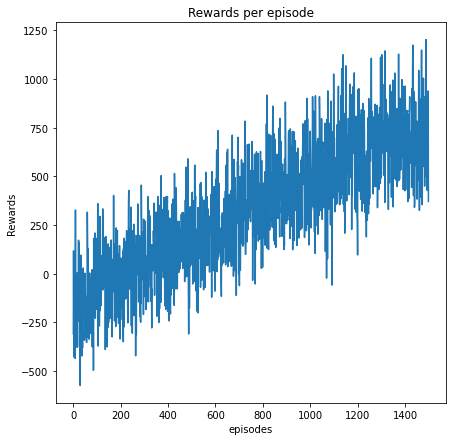

In [22]:
# Plotting rewards per episodes
plt.figure(0, figsize=(7,7))
ax = np.asarray(range(0, len(score_tracker)))
plt.plot(ax,np.asarray(score_tracker))
plt.title('Rewards per episode')
plt.xlabel('episodes')
plt.ylabel('Rewards')
plt.show()


Conclusion: From the given plot, It can be seen that rewards has converged around 1200. Results would have been obvious if model was trained for longer episodes. Due to system limitation it wasn't possible to train such long.

### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [23]:
import numpy as np
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append((1 - 0.00001) * np.exp(-0.0005 * i))

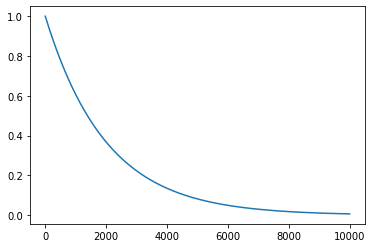

In [24]:
import matplotlib.pyplot as plt
plt.plot(time, epsilon)
plt.show()